# Milk Production
Today there are many different milk alternatives on the grocery store shelves.  It seems as though fewer children and adults are drinking milk.  There are also more people in the US than there were in the past. I am curious if milk production has been trending downwards or upwards.  

## Executive Summary
 - Milk prices are not correlated to the supply of milk.
 - Milk production is cyclical with predicatable peaks.
 - There is a statistical difference between the January and May quantities of milk produced.
 - Both the amount of milk and the amount of milk per person produced in the USA has been increasing over time.
 

## Data Sources
I obtained my data from several different sources.  Cornell has a list of documents from the USDA that have monthly production estimates.  However, the states they sample from to form the estimates change over time. This means that it true year on year comparisons are best from 1960-1985 or 1996-2018.  I used factors to predict the US production based on the sampling production, but there will be some error associated with those factors. I merged my data set from US prodution with data on the US population from 1960-present and commodities pricing of milk, cattle, calves, corn, and soy.

Notes on data: 
1. 1960-1985 all 50 states were used for the estimates.  
2. 1982 from April-December, only quarterly data available, data set filled in with 1/3 amount for each month
3. 1985-1993, 21 producing states sampled, I used factor of 1.185 to estimate 50 state total.  I picked this factor because New Mexico was 2.4% of the total US production in 1995, so I made the factor larger than the 1994-1995 factor to accomodate this.
4. 1994-1995, 22 producting states sampled, I used factor of 1.161 to estimate 50 state production, based on how production changed from February 1995 to February 1996
3. 1996-2018, 23 producing states sampled, data also estimates values for all 50 states
                   
USDA: http://usda.mannlib.cornell.edu/MannUsda/viewDocumentInfo.do?documentID=1103 <br>
US Population: http://www.multpl.com/united-states-population/table?f=m <br>
Commodities Pricing: http://www.farmdoc.illinois.edu/manage/uspricehistory/us_price_history.html

In [1]:
# Import libraries needed
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
% matplotlib inline

In [2]:
# Import monthly milk production in millions of pounds
header = ['Year', 'Month', 'Sample_Prod', 'Num_States', 'Est_USA_Prod']
production = pd.read_csv('Milk_Prod/Milk_Production_Estimates-Table 1.csv')
production.columns = header
print(production.head())
print(production.dtypes)
print(production.info())

   Year     Month  Sample_Prod  Num_States  Est_USA_Prod
0  1960   January         9820          50          9820
1  1960  February         9580          50          9580
2  1960     March        10663          50         10663
3  1960     April        11020          50         11020
4  1960       May        12206          50         12206
Year             int64
Month           object
Sample_Prod      int64
Num_States       int64
Est_USA_Prod     int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 5 columns):
Year            703 non-null int64
Month           703 non-null object
Sample_Prod     703 non-null int64
Num_States      703 non-null int64
Est_USA_Prod    703 non-null int64
dtypes: int64(4), object(1)
memory usage: 27.5+ KB
None


Here the Sample_Prod is the estimated production in millions of pounds. The USDA makes this estimation using sampling from a number of states.  The issue with this is over time, the number and group of states sampled from has changed and the estimate only covers those states. The EST_USA_Prod column is the estimated overall USA production.  Where this was not supplied by the USDA, I used a coefficient to estimate what it would be.  However, this is an estimate projected from an estimate, so the actual value is likely offset from this value.

In [3]:
# Import in US Population Information
us_pop = pd.read_csv('US_Pop-Table 1.csv')
us_pop.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

# Split the month and year columns so that it can be merged with the production data frame
us_pop['Split'] = us_pop.Date.str.split(' ')
us_pop['Month'] = us_pop.Split.str.get(0)
us_pop['Year'] = us_pop.Split.str.get(1).astype(int) #Need to change type of year column to int to merge
us_pop.drop(columns=['Split', 'Date'], inplace=True)
us_pop.columns = ['US_Pop', 'Month', 'Year']

print(us_pop.head())
print(us_pop.US_Pop.describe())
print(us_pop.dtypes)

   US_Pop      Month  Year
0  328.48  September  2018
1  328.26     August  2018
2  328.03       July  2018
3  327.83       June  2018
4  327.63        May  2018
count    432.000000
mean     262.618472
std       64.425683
min       76.090000
25%      253.890000
50%      282.825000
75%      307.332500
max      328.480000
Name: US_Pop, dtype: float64
US_Pop    float64
Month      object
Year        int64
dtype: object


In [4]:
# Merge dairy_df and population dataframe, population data was annual until 1990
dairy_df = pd.merge(left=production, right=us_pop, how='left', 
                    left_on=['Year', 'Month'], right_on=['Year', 'Month'])
dairy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703 entries, 0 to 702
Data columns (total 6 columns):
Year            703 non-null int64
Month           703 non-null object
Sample_Prod     703 non-null int64
Num_States      703 non-null int64
Est_USA_Prod    703 non-null int64
US_Pop          370 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 38.4+ KB


In [5]:
# Milk price units $/cwt
filepath = 'USPriceHistory/Milk-Time Series-Table 1.csv'
header = ['Date', 'Milk_Price']
milk_price = pd.read_csv(filepath, header=2, usecols=[0,1])
milk_price.columns = header
milk_price['Split'] = milk_price.Date.str.split(' ')
milk_price['Month'] = milk_price.Split.str.get(0)
milk_price['Year'] = milk_price.Split.str.get(1).astype(int) #Need to change type of year column to int to merge
milk_price.drop(columns=['Split', 'Date'], inplace=True)


print(milk_price.head())
print(milk_price.dtypes)

   Milk_Price     Month  Year
0        4.37   January  1960
1        4.29  February  1960
2        4.19     March  1960
3        3.96     April  1960
4        3.82       May  1960
Milk_Price    float64
Month          object
Year            int64
dtype: object


In [6]:
# Corn Price units $/bu
filepath = 'USPriceHistory/US-Corn-Time Series-Table 1.csv'
header = ['Date', 'Corn_Price']
corn_price = pd.read_csv(filepath, header=2, usecols=[0,1])
corn_price.columns = header
corn_price['Split'] = corn_price.Date.str.split(' ')
corn_price['Month'] = corn_price.Split.str.get(0)
corn_price['Year'] = corn_price.Split.str.get(1).astype(int) #Need to change type of year column to int to merge
corn_price.drop(columns=['Split', 'Date'], inplace=True)

print(corn_price.head())
print(corn_price.dtypes)

   Corn_Price     Month  Year
0        1.00   January  1960
1        1.01  February  1960
2        1.02     March  1960
3        1.06     April  1960
4        1.08       May  1960
Corn_Price    float64
Month          object
Year            int64
dtype: object


In [7]:
# Soy Price in $/bu
filepath = 'USPriceHistory/US-Soybeans-Time Series-Table 1.csv'
header = ['Date', 'Soy_Price']
soy = pd.read_csv(filepath, header=2, usecols=[0,1])
soy.columns = header
soy['Split'] = soy.Date.str.split(' ')
soy['Month'] = soy.Split.str.get(0)
soy['Year'] = soy.Split.str.get(1).astype(int) #Need to change type of year column to int to merge
soy.drop(columns=['Split', 'Date'], inplace=True)


print(soy.head())
print(soy.dtypes)

   Soy_Price     Month  Year
0       2.01   January  1960
1       1.99  February  1960
2       1.99     March  1960
3       2.02     April  1960
4       2.00       May  1960
Soy_Price    float64
Month         object
Year           int64
dtype: object


In [8]:
# Corn price in $/bu
filepath = 'USPriceHistory/US-Corn-Time Series-Table 1.csv'
header = ['Date', 'Corn_Price']
corn = pd.read_csv(filepath, header=2, usecols=[0,1])
corn.columns = header
corn['Split'] = corn.Date.str.split(' ')
corn['Month'] = corn.Split.str.get(0)
corn['Year'] = corn.Split.str.get(1).astype(int) #Need to change type of year column to int to merge
corn.drop(columns=['Split', 'Date'], inplace=True)


print(corn.head())
print(corn.dtypes)

   Corn_Price     Month  Year
0        1.00   January  1960
1        1.01  February  1960
2        1.02     March  1960
3        1.06     April  1960
4        1.08       May  1960
Corn_Price    float64
Month          object
Year            int64
dtype: object


In [9]:
# Merge commodity price data frames with my dairy_df dataframe
dairy_df = pd.merge(left=dairy_df, right=milk_price, how='left', 
                    left_on=['Year', 'Month'], right_on=['Year', 'Month'])
dairy_df = pd.merge(left=dairy_df, right=soy, how='left', 
                    left_on=['Year', 'Month'], right_on=['Year', 'Month'])
dairy_df = pd.merge(left=dairy_df, right=corn, how='left', 
                    left_on=['Year', 'Month'], right_on=['Year', 'Month'])

print(dairy_df.head())
print(dairy_df.info(null_counts=True))
print(dairy_df.head())

   Year     Month  Sample_Prod  Num_States  Est_USA_Prod  US_Pop  Milk_Price  \
0  1960   January         9820          50          9820     NaN        4.37   
1  1960  February         9580          50          9580     NaN        4.29   
2  1960     March        10663          50         10663     NaN        4.19   
3  1960     April        11020          50         11020     NaN        3.96   
4  1960       May        12206          50         12206     NaN        3.82   

   Soy_Price  Corn_Price  
0       2.01        1.00  
1       1.99        1.01  
2       1.99        1.02  
3       2.02        1.06  
4       2.00        1.08  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 703 entries, 0 to 702
Data columns (total 9 columns):
Year            703 non-null int64
Month           703 non-null object
Sample_Prod     703 non-null int64
Num_States      703 non-null int64
Est_USA_Prod    703 non-null int64
US_Pop          370 non-null float64
Milk_Price      699 non-null float64
Soy

The historical commodity prices were not listed for the most recent 4 months of the year. If we look at dairy_df.tail(), following, we can see that April-July are not available, but March and earlier are.

In [10]:
dairy_df.tail()

,Year,Month,Sample_Prod,Num_States,Est_USA_Prod,US_Pop,Milk_Price,Soy_Price,Corn_Price
698,2018,March,17812,23,18975,327.28,15.6,9.81,3.51
699,2018,April,17294,23,18397,327.45,NaN,NaN,NaN
700,2018,May,17976,23,19123,327.63,NaN,NaN,NaN
701,2018,June,17214,23,18310,327.83,NaN,NaN,NaN
702,2018,July,17299,23,18350,328.03,NaN,NaN,NaN


### Question 1: How has US milk production changed over time?
To answer this question, I am first going to limit my data selection to the the sample production data from 2004-present because the sampling method of looking at 23 states was consistent over those years.  I will also drop the last 4 months where not all of the data is available.  I will combine the year and month columns into a 'Date' column for graphing purposes.

In [11]:
dairy_23 = dairy_df[dairy_df['Year'] >= 2004]
dairy_23 = dairy_23.dropna()
dairy_23['Date'] = dairy_23['Year'].map(str) + ' ' + dairy_23['Month']
dairy_23['Date'] = pd.to_datetime(dairy_23['Date'], format='%Y %B')
dairy_23.info()
dairy_23.head()
describe_columns = ['Sample_Prod', 'Est_USA_Prod', 'US_Pop', 
                    'Milk_Price', 'Soy_Price', 'Corn_Price']
dairy_23[describe_columns].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 528 to 698
Data columns (total 10 columns):
Year            171 non-null int64
Month           171 non-null object
Sample_Prod     171 non-null int64
Num_States      171 non-null int64
Est_USA_Prod    171 non-null int64
US_Pop          171 non-null float64
Milk_Price      171 non-null float64
Soy_Price       171 non-null float64
Corn_Price      171 non-null float64
Date            171 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 14.7+ KB


,Sample_Prod,Est_USA_Prod,US_Pop,Milk_Price,Soy_Price,Corn_Price
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,15111.076023,16243.684211,310.153509,17.422222,9.960409,3.985789
std,1277.081600,1247.631867,10.388489,3.177472,2.741316,1.452372
min,12301.000000,13530.000000,291.550000,11.300000,5.230000,1.770000
25%,14132.500000,15356.500000,301.365000,15.300000,8.535000,3.255000
50%,15153.000000,16180.000000,310.750000,17.100000,9.710000,3.600000
75%,16087.000000,17228.000000,318.990000,19.500000,12.050000,4.665000
max,17812.000000,18975.000000,327.280000,25.700000,16.200000,7.630000


Looking at the information about the data frame, I have 336 non-null values in each of the the fields.  I used the describe method to see if the max and min values seem reasonable or if there were errors in the data the needed fixing.  The first time I ran this I had some unreasonable values and found a typo on my input data sheet that needed to be fixed.  Next I will look at the boxplot of production by month to see if there are any outlier values that need to be investigated.

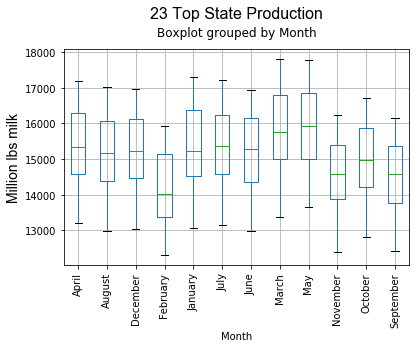

In [12]:
dairy_23.boxplot(column='Sample_Prod', by='Month')

# Set the font dictionaries (for plot title and axis titles)
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'14'}

plt.xticks(rotation=90)
plt.title('23 Top State Production', y=1.10, **title_font)
plt.ylabel('Million lbs milk', **axis_font)
plt.show()

There appears to be some month to month variation which makes sense because calves are born at different times of the year and weather is likely to have an impact as well.  Let's also see if any years have major outliers.

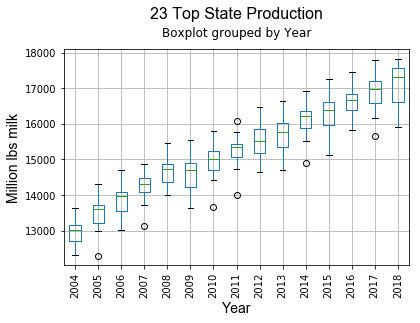

In [13]:
dairy_23.boxplot(column='Sample_Prod', by='Year')
plt.xticks(rotation=90)
plt.title('23 Top State Production', y=1.10, **title_font)
plt.ylabel('Million lbs milk', **axis_font)
plt.xlabel('Year', **axis_font)
plt.show()


It appears the average milk production has overall been rising year on year.  The outliers also appear to be reasonable. Next, I want to look at a line plot of milk production in the 23 sample states from 1990-2018.

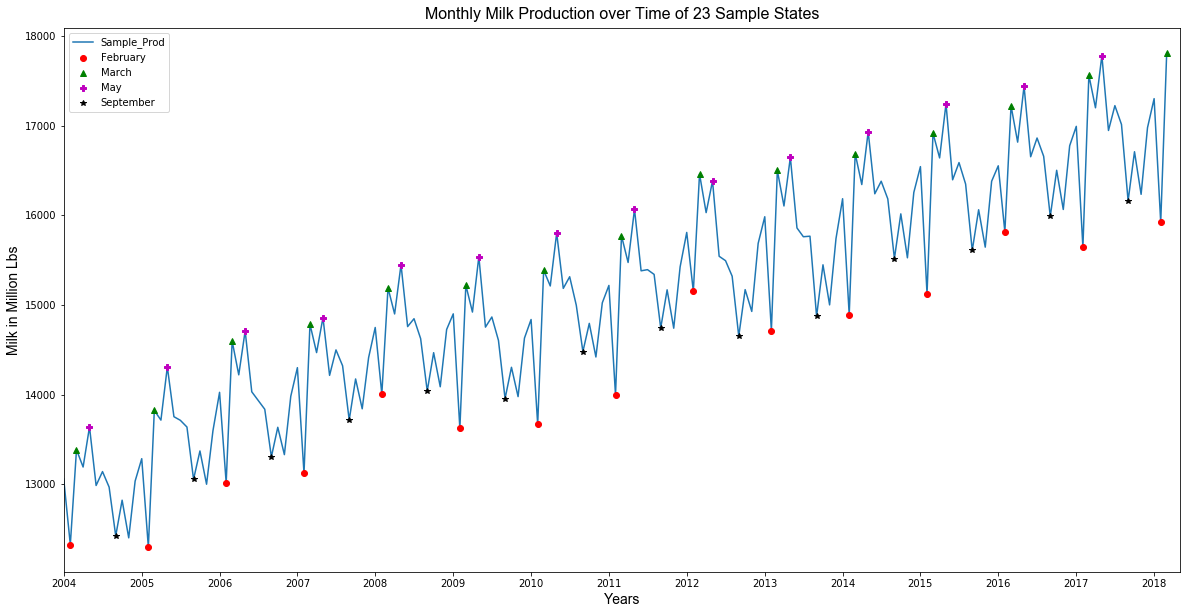

In [14]:
# Set up the plot
fig, ax = plt.subplots(figsize=(20,10))
years = mdates.YearLocator(1) # Markers every 5 years
yearsFmt = mdates.DateFormatter('%Y')

ax.plot(dairy_23['Date'], dairy_23['Sample_Prod']) 

datemin = np.datetime64('2004-01')
datemax = np.datetime64('2018-05')
ax.set_xlim(datemin, datemax)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

plt.xlabel('Years', **axis_font)
plt.ylabel('Milk in Million Lbs', **axis_font)
plt.title('Monthly Milk Production over Time of 23 Sample States', **title_font)

# Add dots for the different months of interest
dairy_feb = dairy_23[dairy_23['Month'] == 'February']
ax.plot(dairy_feb['Date'], dairy_feb['Sample_Prod'], 'ro', label='February')

dairy_mar = dairy_23[dairy_23['Month'] == 'March']
ax.plot(dairy_mar['Date'], dairy_mar['Sample_Prod'], 'g^', label='March')

dairy_may = dairy_23[dairy_23['Month'] == 'May']
ax.plot(dairy_may['Date'], dairy_may['Sample_Prod'], 'Pm', label='May')

dairy_aug = dairy_23[dairy_23['Month'] == 'September']
ax.plot(dairy_aug['Date'], dairy_aug['Sample_Prod'], 'k*', label='September')

# Format the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

plt.show()

#### Answer Question 1:
Milk production has on average been rising over this time period.  This is interesting considering the trend of people drinking alternative milks.  I'm also surprised at how predictable cyclical milk production is.  The same peaks occur every year.

### Question 2: Is the amount of milk produced in February statistically different, as determined by a t-test, than the amount produced in May?


In [15]:
dairy_pivot = pd.pivot_table(dairy_df, index='Month', values='Sample_Prod', 
                             columns=['Year'], aggfunc=np.max, margins=False)

In [16]:
print(dairy_pivot[[1960, 1961, 1962, 2016, 2017, 2018]])

Year          1960     1961     1962     2016     2017     2018
Month                                                          
April      11020.0  11200.0  11232.0  16817.0  17200.0  17294.0
August     10006.0  10270.0  10191.0  16659.0  17014.0      NaN
December    9495.0   9772.0   9813.0  16777.0  16978.0      NaN
February    9580.0   9438.0   9598.0  15817.0  15645.0  15922.0
January     9820.0   9862.0  10111.0  16553.0  16993.0  17302.0
July       10750.0  11057.0  10912.0  16863.0  17224.0  17299.0
June       11689.0  12039.0  11926.0  16654.0  16947.0  17214.0
March      10663.0  10931.0  10994.0  17222.0  17564.0  17812.0
May        12206.0  12375.0  12429.0  17442.0  17783.0  17976.0
November    8974.0   9219.0   9345.0  16066.0  16235.0      NaN
October     9365.0   9672.0   9740.0  16503.0  16710.0      NaN
September   9352.0   9621.0   9636.0  15989.0  16162.0      NaN


In [17]:
# Normalize each year to a max of 1 by dividing by the year max
for year in range(1960, 2019):
    dairy_pivot[year] = dairy_pivot[year] / dairy_pivot[year].max()

In [18]:
# Unstack the pivotted table to perform analysis
dairy_norm = dairy_pivot.unstack().reset_index(name='Sample_Prod')
print(dairy_norm.head())

   Year     Month  Sample_Prod
0  1960     April     0.902835
1  1960    August     0.819761
2  1960  December     0.777896
3  1960  February     0.784860
4  1960   January     0.804522


In [19]:
# My two samples are the normalized monthly January production and the normalized 
# monthly May production
sample1 = dairy_norm[dairy_norm['Month'] == 'February']['Sample_Prod']
sample2 = dairy_norm[dairy_norm['Month'] == 'May']['Sample_Prod']

In [20]:
print(ttest_ind(sample2, sample1, equal_var=False))

Ttest_indResult(statistic=27.927099653662967, pvalue=2.4527861182606134e-35)


#### Answer Question 2:
The p value is small, so we can be reasonable certain that the difference between the normalized mean milk production in January is different from the normalized mean milk production in May.

### Question 3: From January 2004 - December 2017, how has the total milk produced each month varied?

Month
December     212665
February     197417
January      212458
July         214035
June         212717
March        219530
May          222826
November     203217
October      208665
September    202537
Name: Sample_Prod, dtype: int64


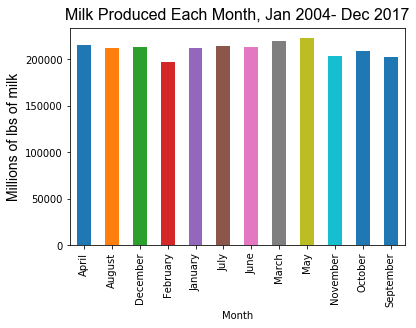

In [21]:
# Draw a bar graph of the monthly production of milk in millions of lbs 
# Need to omit 2018 data because it is not for a complete year
months = dairy_23[dairy_23['Year'] < 2018].groupby('Month').Sample_Prod.sum()
print(months.tail(10))
months.plot.bar()
plt.ylabel('Millions of lbs of milk', **axis_font)
plt.title('Milk Produced Each Month, Jan 2004- Dec 2017', **title_font)
plt.show()

#### Answer 3:
There is a difference in the total amount of milk produced each month over these years.  However, it is also a small percentage compared to the overall volume of milk.

### Question 4: The population in the US has also been growing, has the milk produced per person increased, or is the increase in milk due solely to population growth?
First I will make a scatter plot of US population growth vs. milk produced.  I believe they are correlated (they both increase over time).  Next I will create a new column in my dataframe Milk_Per_Person to show the amount of milk per person produced and graph that versus time.

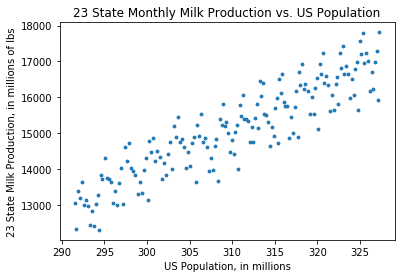

In [22]:
plt.scatter(dairy_23['US_Pop'], dairy_23['Sample_Prod'], s=8)
ax.set_xlim(datemin, datemax)

# format the ticks - use same years definition as previous plot

plt.title('23 State Monthly Milk Production vs. US Population')
plt.xlabel('US Population, in millions')
plt.ylabel('23 State Milk Production, in millions of lbs')

plt.show()

As suspected, these two are positively correlated. Now, let's see what happens when we look at milk per person over time.  

     Year     Month  Sample_Prod  Num_States  Est_USA_Prod  US_Pop  \
528  2004   January        13061          23         14402  291.55   
529  2004  February        12329          23         13595  291.72   
530  2004     March        13387          23         14762  291.89   
531  2004     April        13194          23         14519  292.11   
532  2004       May        13641          23         15012  292.35   

     Milk_Price  Soy_Price  Corn_Price       Date  Milk_Per_Person  
528        13.2       7.35        2.39 2004-01-01         5.743959  
529        13.6       8.28        2.61 2004-02-01         5.418943  
530        15.4       9.28        2.75 2004-03-01         5.880680  
531        18.1       9.62        2.89 2004-04-01         5.779521  
532        19.3       9.56        2.87 2004-05-01         5.970862  


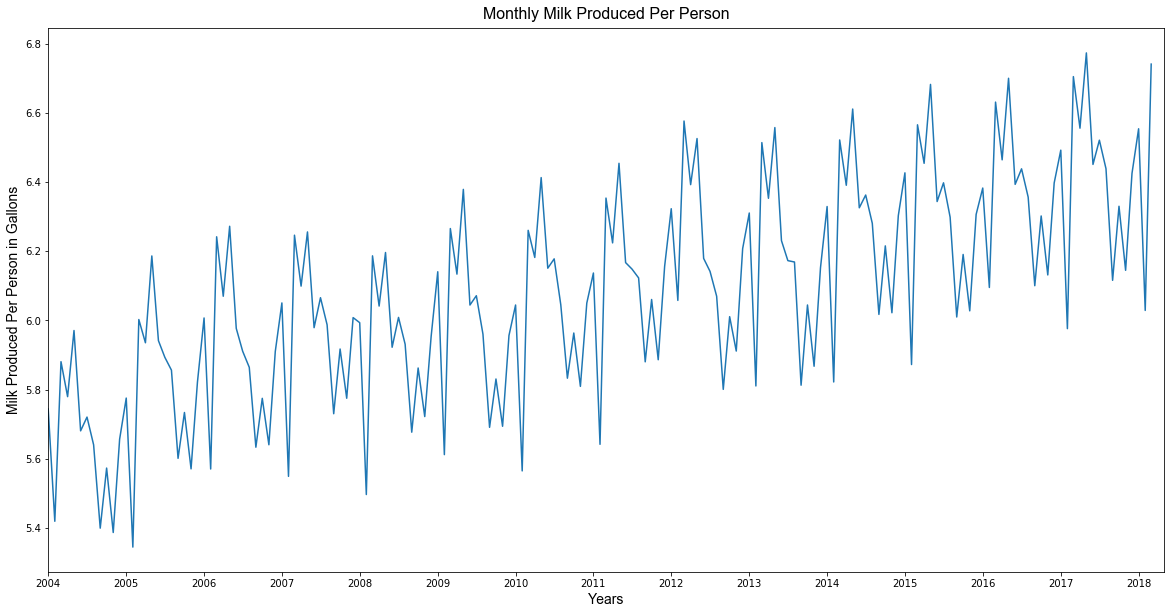

In [23]:
# Create new column for milk per person, convert to gallons per person
# Using estimated US milk because I have population values for all of the USA
dairy_23['Milk_Per_Person'] = dairy_23['Est_USA_Prod'] / dairy_23['US_Pop'] / 8.6
print(dairy_23.head())

fig, ax = plt.subplots(figsize=(20,10))
years = mdates.YearLocator(1) # Markers every 5 years
yearsFmt = mdates.DateFormatter('%Y')


ax.plot(dairy_23['Date'], dairy_23['Milk_Per_Person']) 

datemin = np.datetime64('2004-01')
datemax = np.datetime64('2018-05')
ax.set_xlim(datemin, datemax)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

plt.xlabel('Years', **axis_font)
plt.ylabel('Milk Produced Per Person in Gallons', **axis_font)
plt.title('Monthly Milk Produced Per Person', **title_font)

plt.show()

It appears that the amount of milk produced per person in the USA has actually been increasing over time. The trend is a little hard to see because of the noise in the month to month fluctuations.  I want to plot it on yearly production next.

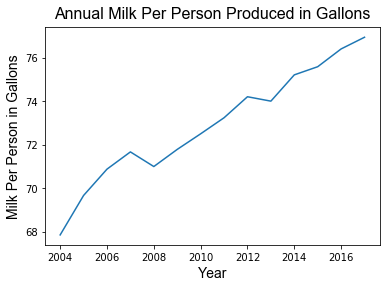

In [24]:
year_prod = dairy_23.groupby(['Year'])['Milk_Per_Person'].sum()

# Omit 2018 because it was only a partial year of data
year_prod.iloc[:-1].plot() 

plt.title('Annual Milk Per Person Produced in Gallons', **title_font)
plt.xlabel('Year', **axis_font)
plt.ylabel('Milk Per Person in Gallons', **axis_font)
plt.show()

This is interesting because the overall trend has been for more milk per person in the USA to be produced each year. I did some reading online and this is likely a result of both more milk being exported than in the past, and while people are driking less milk, they are eating more cheese.   

### Question 4: How does the price of milk (commodity) relate to the amount of milk produced?

             Sample_Prod  Milk_Price
Sample_Prod     1.000000    0.299199
Milk_Price      0.299199    1.000000


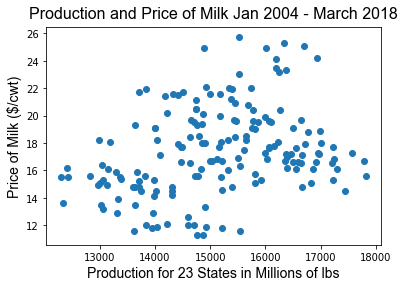

In [25]:
# Looking at correlation between price and production amount 
# Jan 2004 - March 2018
plt.scatter(dairy_23['Sample_Prod'], dairy_23['Milk_Price'])
plt.title('Production and Price of Milk Jan 2004 - March 2018', **title_font)
plt.xlabel('Production for 23 States in Millions of lbs', **axis_font)
plt.ylabel('Price of Milk ($/cwt)', **axis_font)
plt.plot()

print(dairy_23[['Sample_Prod', 'Milk_Price']].corr())

#### Answer Question 4:
Interestingly, there appears to be very little correlation between the monthly price of milk and the monthly production of milk. This means that the purchasers of the milk likely know about the cyclical nature and overall increasing trend of milk production.  

### Question 5: Since the price of milk is not strongly correlated to the amount of milk produced, is it correlated to the price of other commodities such as corn or soy?

            Milk_Price  Corn_Price
Milk_Price    1.000000    0.489107
Corn_Price    0.489107    1.000000


[]

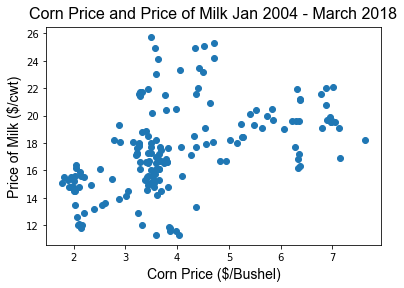

In [26]:
print(dairy_23[['Milk_Price', 'Corn_Price']].corr())
# Looking at correlation between price and production amount 
# Jan 2004 - March 2018
plt.scatter(dairy_23['Corn_Price'], dairy_23['Milk_Price'])
plt.title('Corn Price and Price of Milk Jan 2004 - March 2018', **title_font)
plt.xlabel('Corn Price ($/Bushel)', **axis_font)
plt.ylabel('Price of Milk ($/cwt)', **axis_font)
plt.plot()


            Milk_Price  Soy_Price
Milk_Price    1.000000   0.594105
Soy_Price     0.594105   1.000000


[]

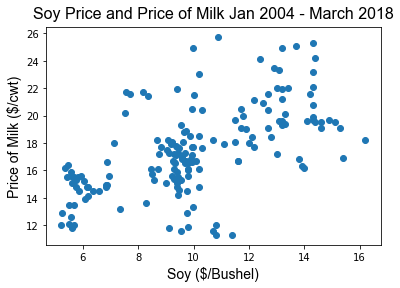

In [27]:
print(dairy_23[['Milk_Price', 'Soy_Price']].corr())

plt.scatter(dairy_23['Soy_Price'], dairy_23['Milk_Price'])
plt.title('Soy Price and Price of Milk Jan 2004 - March 2018', **title_font)
plt.xlabel('Soy ($/Bushel)', **axis_font)
plt.ylabel('Price of Milk ($/cwt)', **axis_font)
plt.plot()

#### Answer Question 5:
There is a little more correlation between the prices of corn and soy and the price of milk than there is to production and the price of milk.  This could either mean that commodity prices tend to rise together or that milk becomes more expensive when the price of feed commodities rises.  

## Future Research Proposed

1. Attempt to predict the price of milk based on other factors such as the price of other commodities, the supply, export levels, and possibly the weather. I know in CA there are also quota systems in place that likely affect this. This could be done using a neural network.  So far I haven't found strong correlations between the price and any single factor, so it may be difficult to predict this.  

2. Predict the selling price of dairies. Dairies can sell for millions of dollars so getting this price right matters a lot to both the buyer and the seller.  Dairies come in many different forms, so possibly this would need to be a cluster analysis grouping types of diaries and prices together.  Or possibly it is only related to the number of cows and volume of milk produced, at which point a regression model may work.  The challenging part would likely be finding the historical prices of dairies sold.     